In [18]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit import Aer, execute, QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.test.mock import FakeProvider
from qiskit.test.mock import FakeParis
from qiskit.providers.aer import AerSimulator
from math import pi

# Importing functions to run on real device
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

# Let first define full, generic multiplication circuit with user input

In [26]:
# Define functions used in the circuit definitions
# Mainly based on the "https://medium.com/@sashwat.anagolum/arithmetic-on-quantum-computers-multiplication-4482cdc2d83b"
def createInputState(qc, reg, n, pie):
    """
    Computes the quantum Fourier transform of reg, one qubit at
    a time.
    Apply one Hadamard gate to the nth qubit of the quantum register reg, and 
    then apply repeated phase rotations with parameters being pi divided by 
    increasing powers of two.
    """
    qc.h(reg[n])
    for i in range(0, n):
        qc.cp(pie / float(2**(i + 1)), reg[n - (i + 1)], reg[n])


def evolveQFTState(qc, reg_a, reg_b, n, pie, factor):
    """  
    Evolves the state |F(ψ(reg_a))> to |F(ψ(reg_a+reg_b))> using the quantum 
    Fourier transform conditioned on the qubits of the reg_b.
    Apply repeated phase rotations with parameters being pi divided by 
    increasing powers of two.
    """
    l = len(reg_b)
    for i in range(0, n + 1):
        if (n - i) > l - 1:
            pass
        else:
            qc.cp(factor*pie / float(2**(i)), reg_b[n - i], reg_a[n])


def inverseQFT(qc, reg, n, pie):
    """
    Performs the inverse quantum Fourier transform on a register reg.
    Apply repeated phase rotations with parameters being pi divided by 
    decreasing powers of two, and then apply a Hadamard gate to the nth qubit
    of the register reg.
    """
    for i in range(0, n):
        qc.cp(-1 * pie / float(2**(n - i)), reg[i], reg[n])
    qc.h(reg[n])


def add(reg_a, reg_b, circ, factor):
    """
    Add two quantum registers reg_a and reg_b, and store the result in 
    reg_a.
    """
    pie = pi
    n = len(reg_a) - 1

    # Compute the Fourier transform of register a
    for i in range(0, n + 1):
        createInputState(circ, reg_a, n - i, pie)
    # Add the two numbers by evolving the Fourier transform F(ψ(reg_a))>
    # to |F(ψ(reg_a+reg_b))>
    for i in range(0, n + 1):
        evolveQFTState(circ, reg_a, reg_b, n - i, pie, factor)
    # Compute the inverse Fourier transform of register a
    for i in range(0, n + 1):
        inverseQFT(circ, reg_a, i, pie)

In [90]:
# # Take two numbers as user input in binary form
l1 = 0
l2 = 0
while( (l1 == 0) | (l1 > 3 ) | (l2 == 0) | (l2 > 3) ):
        print("From loop")
        multiplicand_in = input("Enter the multiplicand in binary (max 3 bits long)")
        l1 = len(multiplicand_in)
        multiplier_in = input("Enter the multiplier in binary (max 3 bits long).")
        l2 = len(multiplier_in)

        # Make sure that numbers are not too long    
        if (l1 > 3) | (l2 > 3) : 
            print("Number too big. Try again!")

            
# Make sure multiplicand_in holds the larger number
if l2 > l1:
    multiplier_in, multiplicand_in = multiplicand_in, multiplier_in
    l2, l1 = l1, l2

From loop
Enter the multiplicand in binary (max 3 bits long)10
Enter the multiplier in binary (max 3 bits long).10


In [91]:
# define all registers and quantum and classical qubits used in circuit
multiplicand = QuantumRegister(l1,"mltpd")
multiplier = QuantumRegister(l2,"mltpr")
accumulator = QuantumRegister(l1 + l2,"acc")
cl = ClassicalRegister(l1 + l2,"classical")
ctrl = QuantumRegister(1,"ctrl")

circ = QuantumCircuit(accumulator, multiplier, multiplicand, ctrl, cl, name="Multiplication circuit")

In [92]:
# Store bit strings in quantum registers
for i in range(l1):
    if multiplicand_in[i] == '1':
        circ.x(multiplicand[l1 - i - 1])

for i in range(l2):
    if multiplier_in[i] == '1':
        circ.x(multiplier[l2 - i - 1])
        
circ.x(ctrl)

In [93]:
circ.barrier()    

In [94]:
multiplier_str = '1'
# Perform repeated addition until the multiplier
# is zero
while(int(multiplier_str) != 0):
    add(accumulator, multiplicand, circ, 1)
    add(multiplier, ctrl, circ, -1)
    for i in range(len(multiplier)):
        circ.measure(multiplier[i], cl[i])
    result = execute(circ, backend=Aer.get_backend('qasm_simulator'),
                    shots=2).result().get_counts(circ.name)
    multiplier_str = list(result.keys())[0]

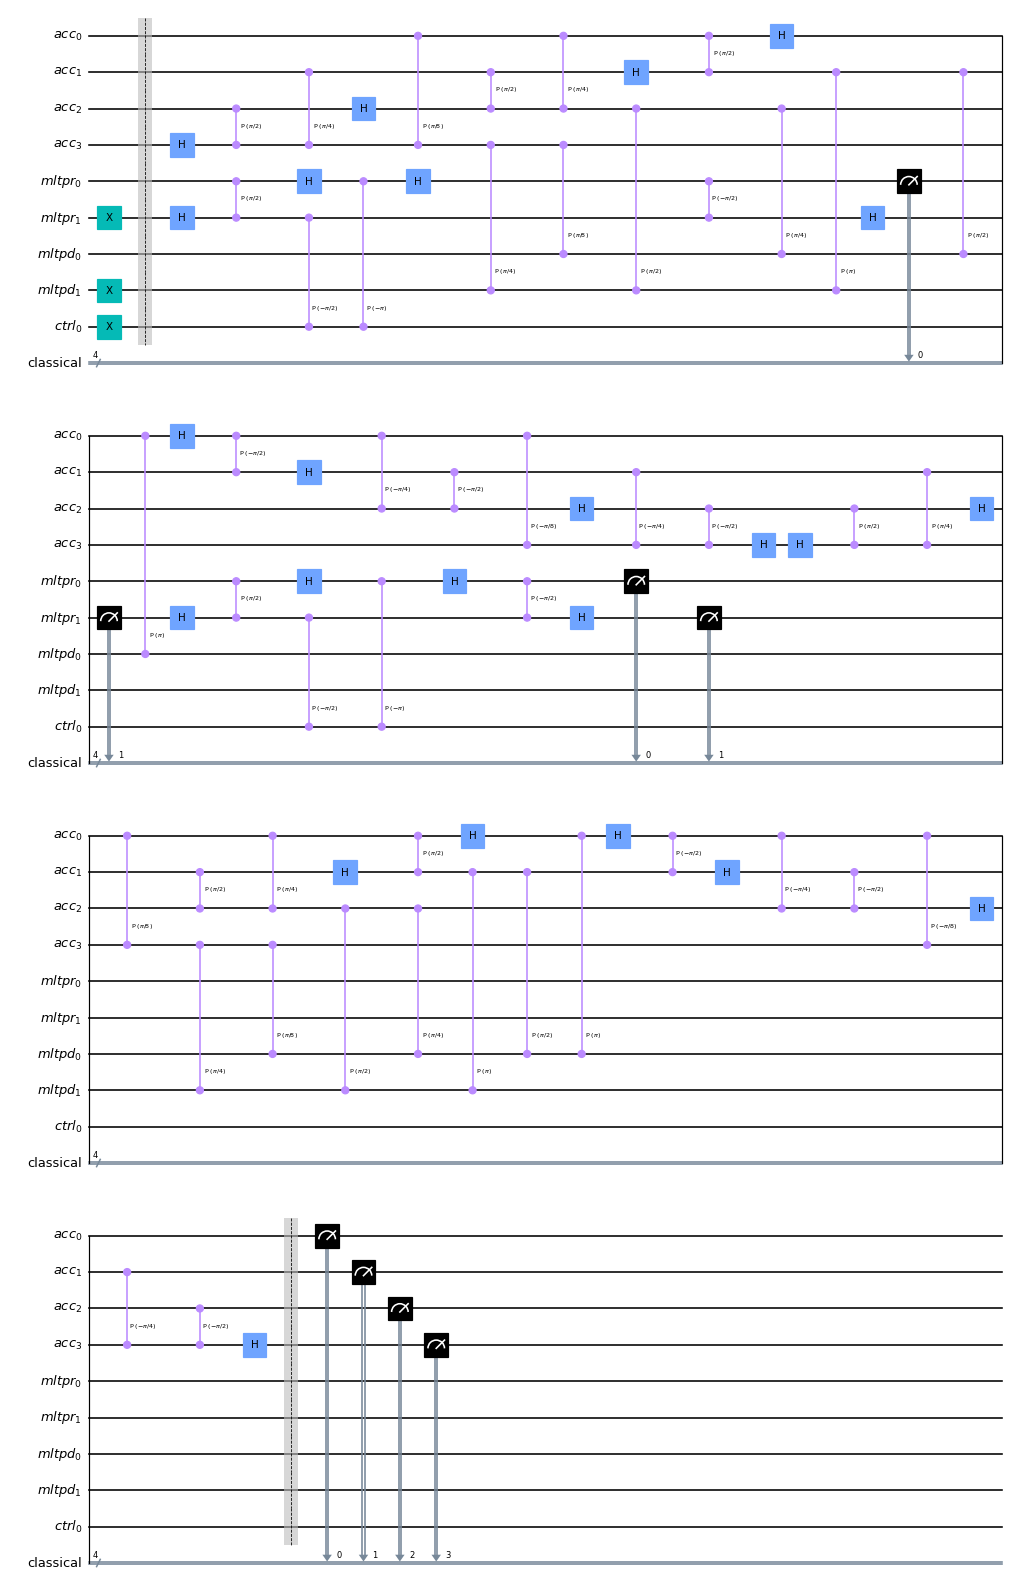

In [95]:
circ.barrier()    
circ.measure(accumulator, cl)
circ.draw("mpl",vertical_compression='high',scale=0.8)


## Let run the full circuit on the QASM simulator

In [108]:
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-04-30 08:42:00,182: Credentials are already in use. The existing account in the session will be replaced.


Product of 10 and 10 equals =  0100 using QASM simulator.


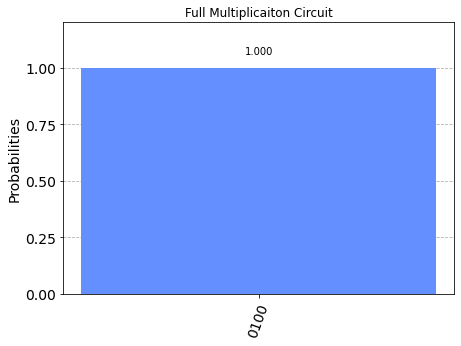

In [112]:
result_fullc_2x2_qasm = execute(circ, backend=Aer.get_backend('qasm_simulator'),
            shots=1024).result().get_counts(circ.name)

#print(result)
print("Product of {} and {} equals =  {} using QASM simulator.".format(multiplicand_in, multiplier_in, list(result.items())[0][0]))
plot_histogram(result_fullc_2x2_qasm, title="Full Multiplicaiton Circuit")

## Let run the full circuit on the QASM simulator with emulated noise

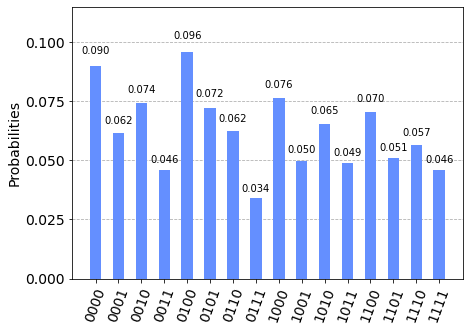

In [244]:
# execute circuit on the noisy qc
device_backend2 = FakeParis()
sim_paris = AerSimulator.from_backend(device_backend2)

# Transpile the circuit for the noisy basis gates
noisy_add_circuit = transpile(circ, sim_paris)

# Execute noisy simulation and get counts on 2 different emulated noisy QCs
result = sim_paris.run(noisy_add_circuit).result()
result_fullc_2x2_qasm_noise = result.get_counts(circ)
plot_histogram(result_fullc_2x2_qasm_noise)

## Let run the same on the real QC

In [189]:
# define amount of required qubits
m = 3 + 3 + 6 + 1
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
provider = IBMQ.get_provider()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= m and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", backend)

ibmqfactory.load_account:WARNING:2021-05-01 06:04:33,567: Credentials are already in use. The existing account in the session will be replaced.


Running on current least busy device:  ibmq_16_melbourne


In [190]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
transpiled_add_circuit = transpile(circ, backend, optimization_level=3)

# Create a Quantum Program for execution
job_real_qc = execute(transpiled_add_circuit, backend)
job_monitor(job_real_qc, interval=2)

Job Status: job has successfully run


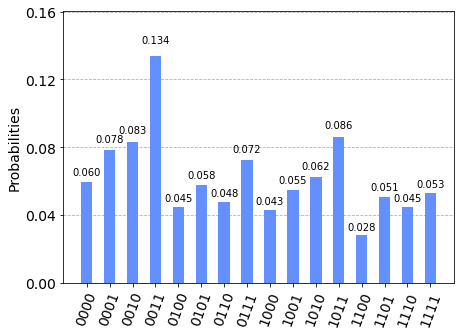

In [185]:
# Get the results from the computation
results_mbern = job_real_qc.result()
result_fullc_2x2_qc_melb = results_mbern.get_counts(circ)
plot_histogram(result_fullc_2x2_qc_melb) 

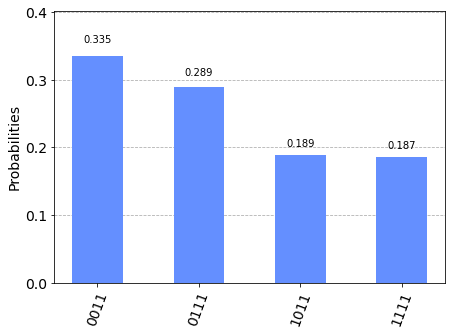

In [191]:
# Get the results from the computation - try 2
results_mbern2 = job_real_qc.result()
result_fullc_2x2_qc_melb2 = results_mbern2.get_counts(circ)
plot_histogram(result_fullc_2x2_qc_melb2) 

# now simplified 2x2 circuit

In that circuit I will simplify the circuit, and reduce number of qubits used, so that it can fit on QCs with 5 qubits.
I will eliminate CTRL part of the circuit and remove multiplier register.
Insted, I will repeat twice quantum addition part of the circuit.
I will also reduce number of qubits in accumulator to 3 (which allows to fit nuber up to 8).
After all is done I will be able to run quantum 2*2 using only 5 qubits.

In [129]:
# define multiplicand and multiplier
# note - multiplier not really needed
multiplicand_in = "10"
l1 = len(multiplicand_in)
#multiplier_in = "10"
#l2 = len(multiplier_in)

    
# define all registers and quantum and classical qubits used in my circuit
# circuit size:
# register 1 and register 2 - 2 qubits. Accumulator 3x3 = 9.
# total 4x2 + 1 = 9 qubits, and 4 classical bits
multiplicand = QuantumRegister(l1,"mltpd")
#multiplier = QuantumRegister(l2,"mltpr")
accumulator = QuantumRegister(l1 + 1,"acc")
cl = ClassicalRegister(l1 + 1,"cl")

In [130]:
circ2x2 = QuantumCircuit(multiplicand, accumulator, cl, name="2x2 circuit - simplified - 5 qubits")

In [131]:
# Store bit strings in quantum registers
for i in range(l1):
    if multiplicand_in[i] == '1':
        circ2x2.x(multiplicand[l1 - i - 1])

# for i in range(l2):
#     if multiplier_in[i] == '1':
#         circ2x2.x(multiplier[l1 - i - 1])

circ2x2.barrier()        
        
#circ2x2.draw("mpl",vertical_compression='high',scale=0.8)

In [132]:
# modified add with 2 rotations in the row and no inverse QFT at the end 
def modified_add_2_times(reg_a, reg_b, circ, factor):
    """
    Add two quantum registers reg_a and reg_b, and store the result in 
    reg_a.
    """
    pie = pi
    n = len(reg_a) - 1

    # Compute the Fourier transform of register a
    for i in range(0, n + 1):
        createInputState(circ, reg_a, n - i, pie)
    # Add the two numbers by evolving the Fourier transform F(ψ(reg_a))>
    # to |F(ψ(reg_a+reg_b))>
    for i in range(0, n + 1):
        evolveQFTState(circ, reg_a, reg_b, n - i, pie, factor)
        
    # Add the two numbers by evolving the Fourier transform F(ψ(reg_a))>
    # to |F(ψ(reg_a+reg_b))>
    for i in range(0, n + 1):
        evolveQFTState(circ, reg_a, reg_b, n - i, pie, factor)
        

In [133]:
modified_add_2_times(accumulator, multiplicand, circ2x2, 1)
circ2x2.barrier() 

# Compute the inverse Fourier transform of register a
for i in range(0, l1 + 1):
    inverseQFT(circ2x2, accumulator, i, pi)

circ2x2.barrier() 

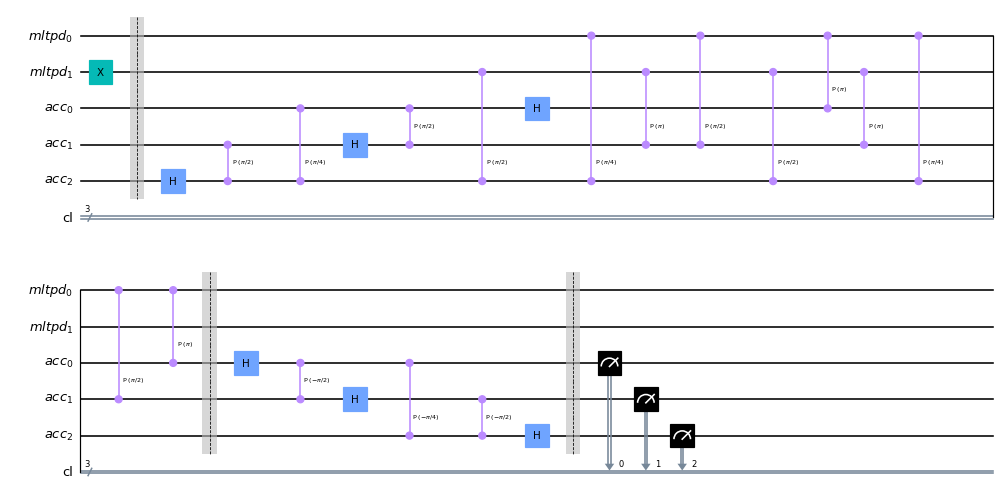

In [134]:
circ2x2.measure(accumulator, cl)
circ2x2.draw("mpl",vertical_compression='high',scale=0.8)

## execute circuit on the perfect quantum computer

Measurement result is =  {'100': 1024}


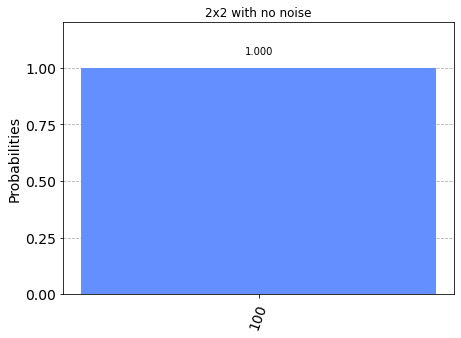

In [135]:
# execute circuit on the perfect quantum computer
result_simpc_2x2_qasm = execute(circ2x2, backend=Aer.get_backend('qasm_simulator'),
            shots=1024).result().get_counts(circ2x2.name)


print("Measurement result is = ",result_simpc_2x2_qasm)
plot_histogram(result_simpc_2x2_qasm,title="2x2 with no noise")


## execute circuit on the noisy quantum computer

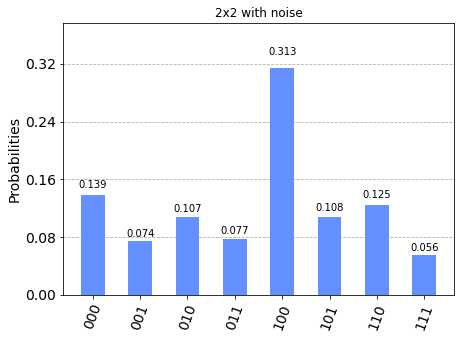

In [192]:
# execute circuit on the noisy qc

device_backend2 = FakeParis()
sim_paris = AerSimulator.from_backend(device_backend2)

# Transpile the circuit for the noisy basis gates
noisy_add_circuit = transpile(circ2x2, sim_paris)

# Execute noisy simulation and get counts on 2 different emulated noisy QCs
result_noise = sim_paris.run(noisy_add_circuit).result()



# Get the results from the computation
result_simpc_2x2_qasm_noise = result_noise.get_counts(circ2x2.name)

#print("Measurement result is = ",counts_noise)
plot_histogram(result_simpc_2x2_qasm_noise,title="2x2 with noise")

## Let run the same on the real QC

For comparison let's run it first on the QC in Melbourne (with 15 qubits)

In [186]:
m = 8
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
provider = IBMQ.get_provider()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= m and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", backend)

ibmqfactory.load_account:WARNING:2021-04-30 22:15:29,366: Credentials are already in use. The existing account in the session will be replaced.


Running on current least busy device:  ibmq_16_melbourne


In [187]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
transpiled_add_circuit = transpile(circ2x2, backend, optimization_level=3)

# Create a Quantum Program for execution
job_real_qc = execute(transpiled_add_circuit, backend)
job_monitor(job_real_qc, interval=2)

Job Status: job has successfully run


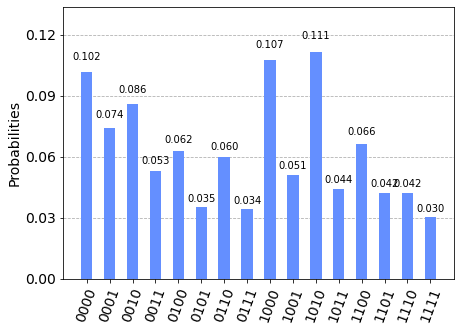

In [188]:
# Get the results from the computation
results = job_real_qc.result()
result_simpc_2x2_qc_melb = results.get_counts(circ2x2)
plot_histogram(answer) 

## Let run the same on the real QC with 5 qubits

In [141]:
m = 5
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
provider = IBMQ.get_provider()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= m and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", backend)

ibmqfactory.load_account:WARNING:2021-04-30 09:50:39,734: Credentials are already in use. The existing account in the session will be replaced.


Running on current least busy device:  ibmq_quito


In [142]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
transpiled_add_circuit = transpile(circ2x2, backend, optimization_level=3)

# Create a Quantum Program for execution
job_real_qc = execute(transpiled_add_circuit, backend)
job_monitor(job_real_qc, interval=2)

Job Status: job has successfully run


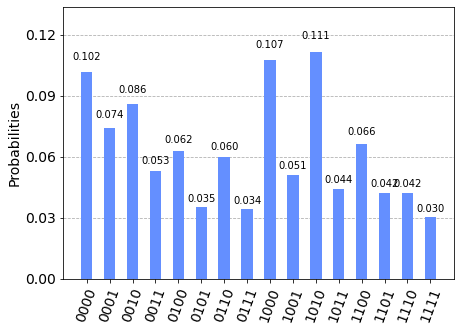

In [143]:
# Get the results from the computation
results = job_real_qc.result()
result_simpc_2x2_qc_5qb = results.get_counts(circ2x2)
plot_histogram(answer) 

## Let run the same on specific  QC with 5 qubits

In [153]:
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
provider = IBMQ.get_provider()
backend = provider.get_backend('ibmq_athens')
# backend_qui = provider.get_backend('ibmq_quito')
# backend_san = provider.get_backend('ibmq_santiago')
# backend_lim = provider.get_backend('ibmq_lima')
# backend_yor = provider.get_backend('ibmq_yorktown')
# backend_bel = provider.get_backend('ibmq_bel')



print("Running on : ", backend)

ibmqfactory.load_account:WARNING:2021-04-30 10:03:49,241: Credentials are already in use. The existing account in the session will be replaced.


Running on :  ibmq_athens


In [155]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
transpiled_add_circuit = transpile(circ2x2, backend, optimization_level=3)
#print("Depth of the transpiled circuit is: ",transpiled_add_circuit.depth()

# Create a Quantum Program for execution
job_real_qc = execute(transpiled_add_circuit, backend)
job_monitor(job_real_qc, interval=2)

Job Status: job has successfully run


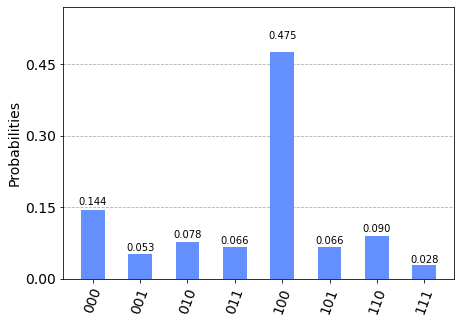

In [157]:
# Get the results from the computation
results = job_real_qc.result()
result_simpc_2x2_qc_athens = results.get_counts(circ2x2)
plot_histogram(result_simpc_2x2_qc_athens) 

## Let run the same on  QC in Lima (with 5 qubits)

In [158]:
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
provider = IBMQ.get_provider()
backend = provider.get_backend('ibmq_lima')
# backend_qui = provider.get_backend('ibmq_quito')
# backend_san = provider.get_backend('ibmq_santiago')
# backend_lim = provider.get_backend('ibmq_lima')
# backend_yor = provider.get_backend('ibmq_yorktown')
# backend_bel = provider.get_backend('ibmq_belem')



print("Running on : ", backend)

ibmqfactory.load_account:WARNING:2021-04-30 14:26:15,435: Credentials are already in use. The existing account in the session will be replaced.


Running on :  ibmq_lima


In [159]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
transpiled_add_circuit = transpile(circ2x2, backend, optimization_level=3)
#print("Depth of the transpiled circuit is: ",transpiled_add_circuit.depth()

# Create a Quantum Program for execution
job_real_qc = execute(transpiled_add_circuit, backend)
job_monitor(job_real_qc, interval=2)

Job Status: job has successfully run


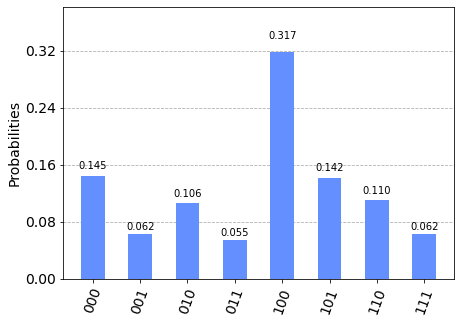

In [160]:
# Get the results from the computation
results = job_real_qc.result()
result_simpc_2x2_qc_lima = results.get_counts(circ2x2)
plot_histogram(result_simpc_2x2_qc_lima) 

## Let run the same on  QC in Belem (with 5 qubits)

In [161]:
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
provider = IBMQ.get_provider()
backend = provider.get_backend('ibmq_belem')
# backend_qui = provider.get_backend('ibmq_quito')
# backend_san = provider.get_backend('ibmq_santiago')
# backend_lim = provider.get_backend('ibmq_lima')
# backend_yor = provider.get_backend('ibmq_yorktown')
# backend_bel = provider.get_backend('ibmq_belem')



print("Running on : ", backend)

ibmqfactory.load_account:WARNING:2021-04-30 17:37:59,965: Credentials are already in use. The existing account in the session will be replaced.


Running on :  ibmq_belem


In [162]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
transpiled_add_circuit = transpile(circ2x2, backend, optimization_level=3)
#print("Depth of the transpiled circuit is: ",transpiled_add_circuit.depth()

# Create a Quantum Program for execution
job_real_qc = execute(transpiled_add_circuit, backend)
job_monitor(job_real_qc, interval=2)

Job Status: job has successfully run


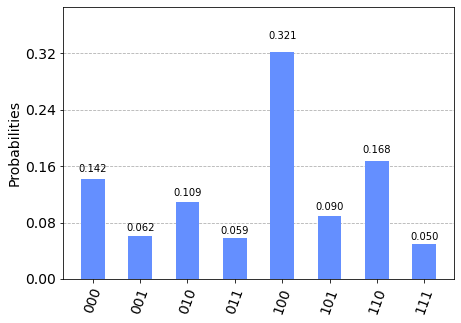

In [163]:
# Get the results from the computation
results = job_real_qc.result()
result_simpc_2x2_qc_belem = results.get_counts(circ2x2)
plot_histogram(result_simpc_2x2_qc_belem) 

## Let run the same on  QC in Santiago (with 5 qubits)

In [164]:
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
provider = IBMQ.get_provider()
backend = provider.get_backend('ibmq_santiago')
# backend_qui = provider.get_backend('ibmq_quito')
# backend_san = provider.get_backend('ibmq_santiago')
# backend_lim = provider.get_backend('ibmq_lima')
# backend_yor = provider.get_backend('ibmq_yorktown')
# backend_bel = provider.get_backend('ibmq_belem')



print("Running on : ", backend)

ibmqfactory.load_account:WARNING:2021-04-30 18:05:10,459: Credentials are already in use. The existing account in the session will be replaced.


Running on :  ibmq_santiago


In [165]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
transpiled_add_circuit = transpile(circ2x2, backend, optimization_level=3)
#print("Depth of the transpiled circuit is: ",transpiled_add_circuit.depth()

# Create a Quantum Program for execution
job_real_qc = execute(transpiled_add_circuit, backend)
job_monitor(job_real_qc, interval=2)

Job Status: job has successfully run


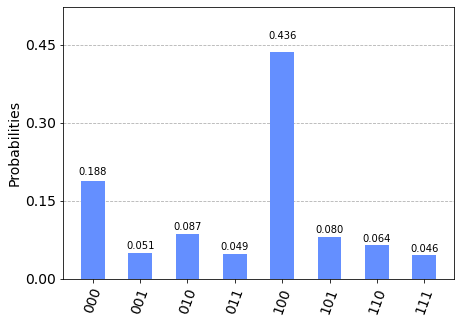

In [166]:
# Get the results from the computation
results = job_real_qc.result()
result_simpc_2x2_qc_santiago = results.get_counts(circ2x2)
plot_histogram(result_simpc_2x2_qc_santiago) 

## Let run the same on  QC in Yorktown (with 5 qubits)

In [173]:
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
provider = IBMQ.get_provider()
backend = provider.get_backend('ibmq_5_yorktown')
# backend_qui = provider.get_backend('ibmq_quito')
# backend_san = provider.get_backend('ibmq_santiago')
# backend_lim = provider.get_backend('ibmq_lima')
# backend_yor = provider.get_backend('ibmq_yorktown')
# backend_bel = provider.get_backend('ibmq_belem')



print("Running on : ", backend)

ibmqfactory.load_account:WARNING:2021-04-30 19:32:11,960: Credentials are already in use. The existing account in the session will be replaced.


Running on :  ibmqx2


In [178]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
transpiled_add_circuit = transpile(circ2x2, backend, optimization_level=3)
#print("Depth of the transpiled circuit is: ",transpiled_add_circuit.depth()

# Create a Quantum Program for execution
job_real_qc = execute(transpiled_add_circuit, backend)
job_monitor(job_real_qc, interval=2)

Job Status: job has successfully run


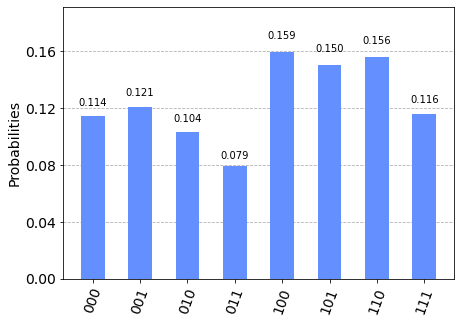

In [179]:
# Get the results from the computation
results = job_real_qc.result()
result_simpc_2x2_qc_yorktown = results.get_counts(circ2x2)
plot_histogram(result_simpc_2x2_qc_yorktown) 

## Let run the same on  QC in Quito (with 5 qubits)

In [180]:
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
provider = IBMQ.get_provider()
backend = provider.get_backend('ibmq_quito')
# backend_qui = provider.get_backend('ibmq_quito')
# backend_san = provider.get_backend('ibmq_santiago')
# backend_lim = provider.get_backend('ibmq_lima')
# backend_yor = provider.get_backend('ibmq_yorktown')
# backend_bel = provider.get_backend('ibmq_belem')



print("Running on : ", backend)

ibmqfactory.load_account:WARNING:2021-04-30 19:38:08,907: Credentials are already in use. The existing account in the session will be replaced.


Running on :  ibmq_quito


In [181]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
transpiled_add_circuit = transpile(circ2x2, backend, optimization_level=3)
#print("Depth of the transpiled circuit is: ",transpiled_add_circuit.depth()

# Create a Quantum Program for execution
job_real_qc = execute(transpiled_add_circuit, backend)
job_monitor(job_real_qc, interval=2)

Job Status: job has successfully run


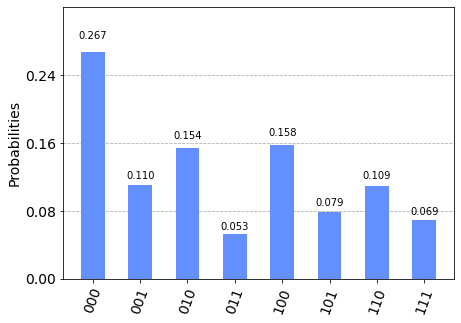

In [182]:
# Get the results from the computation
results = job_real_qc.result()
result_simpc_2x2_qc_quito = results.get_counts(circ2x2)
plot_histogram(result_simpc_2x2_qc_quito) 

# combine results into one plot

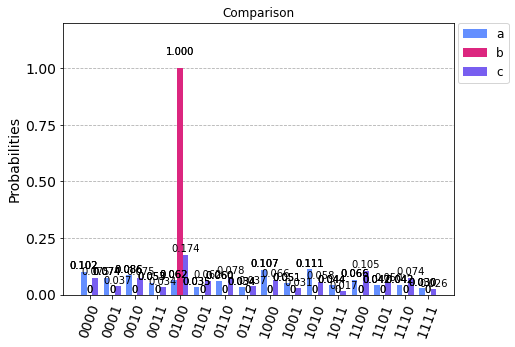

In [85]:
plot_histogram([answer,result,answer_noisy], title="Comparison",legend = ("a","b","c"))




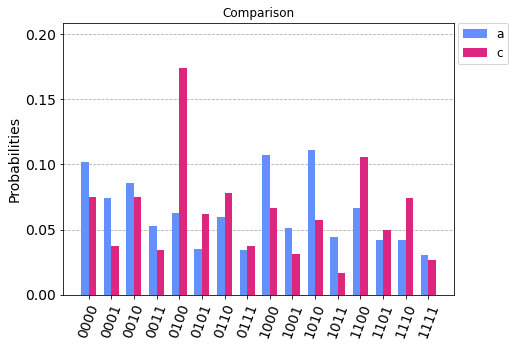

In [102]:
plot_histogram([answer,answer_noisy], title="Comparison",legend = ("a","c",), bar_labels=False )


## First show results of the full and simplified circuit run on the QASM simulator

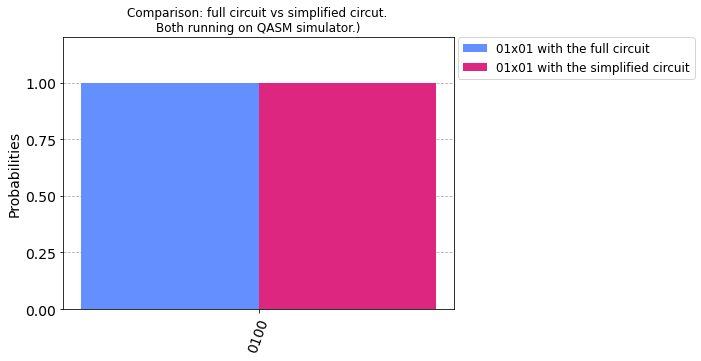

In [233]:
# modify result from the simplified circuit, so that the it is represented in 4 bit string '0100' instead of '100' 
result_simpc_2x2_qasm_mod = {"0100": list(result_simpc_2x2_qasm.items())[0][1]}
#plot_histogram([result_fullc_2x2_qasm,result_simpc_2x2_qasm], title="Comparison: full circuit vs simplified circut. \nBoth running on QASM simulator.)",legend = ("01x01 with the full circuit","01x01 with the simplified circuit"), bar_labels=False)

plot_histogram([result_fullc_2x2_qasm,result_simpc_2x2_qasm_mod], title="Comparison: full circuit vs simplified circut. \nBoth running on QASM simulator.)",legend = ("01x01 with the full circuit","01x01 with the simplified circuit"), bar_labels=False)




##  show results of the full circuit run on QASM with noise and on the real computer

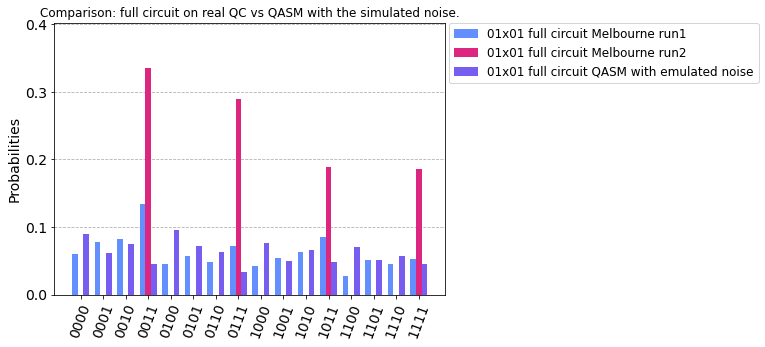

In [246]:
plot_histogram([result_fullc_2x2_qc_melb,result_fullc_2x2_qc_melb2,result_fullc_2x2_qasm_noise], 
               title="Comparison: full circuit on real QC vs QASM with the simulated noise.",
               legend = ("01x01 full circuit Melbourne run1","01x01 full circuit Melbourne run2","01x01 full circuit QASM with emulated noise"), bar_labels=False)



##  show results of thesimplified circuit run on QASM with noise and on the real computers

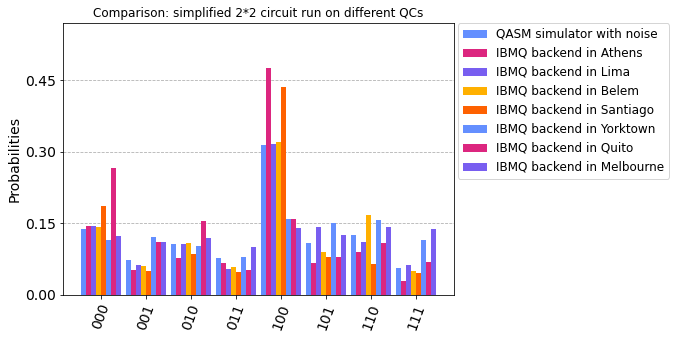

In [254]:
plot_histogram([result_simpc_2x2_qasm_noise,
                result_simpc_2x2_qc_athens,
                result_simpc_2x2_qc_lima,
                result_simpc_2x2_qc_belem,
                result_simpc_2x2_qc_santiago,
                result_simpc_2x2_qc_yorktown,
                result_simpc_2x2_qc_quito,
                result_simpc_2x2_qc_melb], 
                title="Comparison: simplified 2*2 circuit run on different QCs", 
                legend = ("QASM simulator with noise",
                          "IBMQ backend in Athens",
                          "IBMQ backend in Lima",
                          "IBMQ backend in Belem",
                          "IBMQ backend in Santiago",
                          "IBMQ backend in Yorktown",
                          "IBMQ backend in Quito",
                          "IBMQ backend in Melbourne"
                         ), bar_labels=False)

#legend = ("IBM Q backend","QASM simulator with noise"),